In [1]:
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
PATH = "data\\covid_19_data.csv"
PATH_CONFIRM = "data\\time_series_covid_19_confirmed.csv"
PATH_DEATHS = "data\\time_series_covid_19_deaths.csv"
PATH_RECOVERED = "data\\time_series_covid_19_recovered.csv"

In [3]:
data = pd.read_csv(PATH)
confirmed_df = pd.read_csv(PATH_CONFIRM)
deaths_df = pd.read_csv(PATH_DEATHS)
recovered_df = pd.read_csv(PATH_RECOVERED)

In [4]:
data = data.drop("SNo", axis=1)
data = data.drop("Last Update", axis=1)

data.head(10)

,ObservationDate,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,01/22/2020,Anhui,Mainland China,1.0,0.0,0.0
1,01/22/2020,Beijing,Mainland China,14.0,0.0,0.0
2,01/22/2020,Chongqing,Mainland China,6.0,0.0,0.0
3,01/22/2020,Fujian,Mainland China,1.0,0.0,0.0
4,01/22/2020,Gansu,Mainland China,0.0,0.0,0.0
5,01/22/2020,Guangdong,Mainland China,26.0,0.0,0.0
6,01/22/2020,Guangxi,Mainland China,2.0,0.0,0.0
7,01/22/2020,Guizhou,Mainland China,1.0,0.0,0.0
8,01/22/2020,Hainan,Mainland China,4.0,0.0,0.0
9,01/22/2020,Hebei,Mainland China,1.0,0.0,0.0


Xét thông tin ca nhiễm trên một quốc gia

In [250]:
nation = "Italy"
data_1 = data[data["Country/Region"] == nation].reset_index(drop=True)

data_1 = data_1.drop("Province/State", axis=1)
# data_1 = data.drop("Province/State", axis=1)

#Mot so quốc gia được chia theo vùng, một số không, do đó tổng hợp số ca theo ngày trên cả quốc gia
data_1 = data_1.groupby("ObservationDate").agg("sum").reset_index()

data_1.head(10)

,ObservationDate,Confirmed,Deaths,Recovered
0,01/31/2020,2.0,0.0,0.0
1,02/01/2020,2.0,0.0,0.0
2,02/02/2020,2.0,0.0,0.0
3,02/03/2020,2.0,0.0,0.0
4,02/04/2020,2.0,0.0,0.0
5,02/05/2020,2.0,0.0,0.0
6,02/06/2020,2.0,0.0,0.0
7,02/07/2020,3.0,0.0,0.0
8,02/08/2020,3.0,0.0,0.0
9,02/09/2020,3.0,0.0,0.0


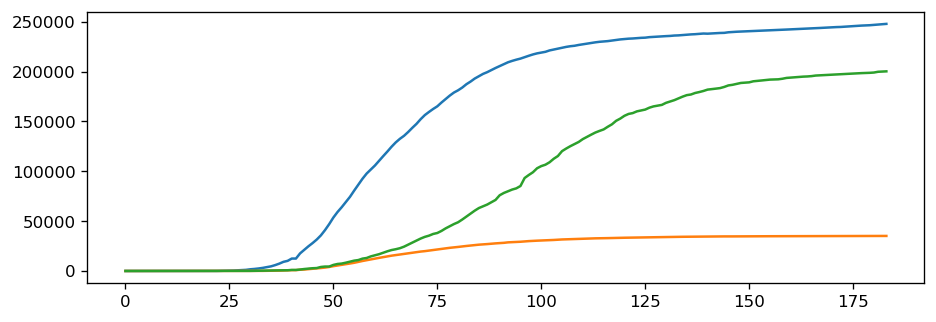

In [251]:
plt.plot(data_1["Confirmed"])
plt.plot(data_1["Deaths"])
plt.plot(data_1["Recovered"]);

### Nhận xét
Số lượng ca mắc, hồi phục và tử vong là các chỉ số luôn tăng theo thời gian, do đó khả năng cao là non-stationary không phù hợp với các mô hình dự báo, tính toán thông tin "Số ca đang mắc" = số ca mắc - số ca tử vong - số ca hồi phục và số ca mới là hiệu số ca mắc sau mỗi ngày.

Mô hình dự đoán được xây dựng dựa trên số ca mới

Tham khảo về stationarity: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

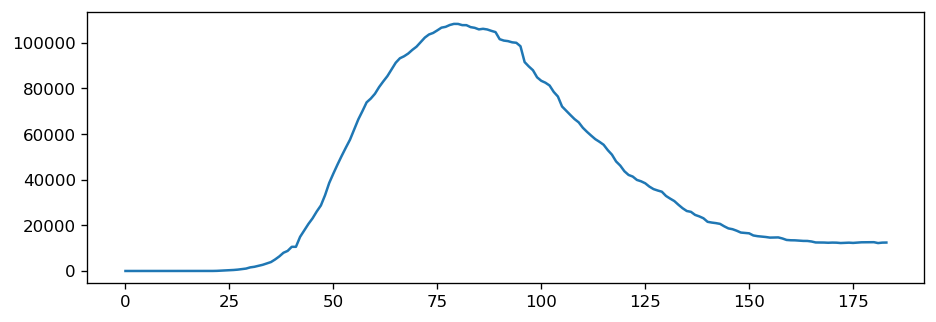

In [252]:
data_1["Active"] = data_1["Confirmed"] - data_1["Recovered"] - data_1["Deaths"]
#Số ca mới
plt.plot(data_1["Active"]);

Ta có p-value = 0.83 > 0.05, như vậy dữ liệu số ca mắc ở VN là non-stationary (phụ thuộc vào biến thời gian)

In [253]:
from statsmodels.tsa.stattools import adfuller

df = data_1[["Active"]].copy()
df = df.reset_index(drop=True)

result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.060551
p-value: 0.001125


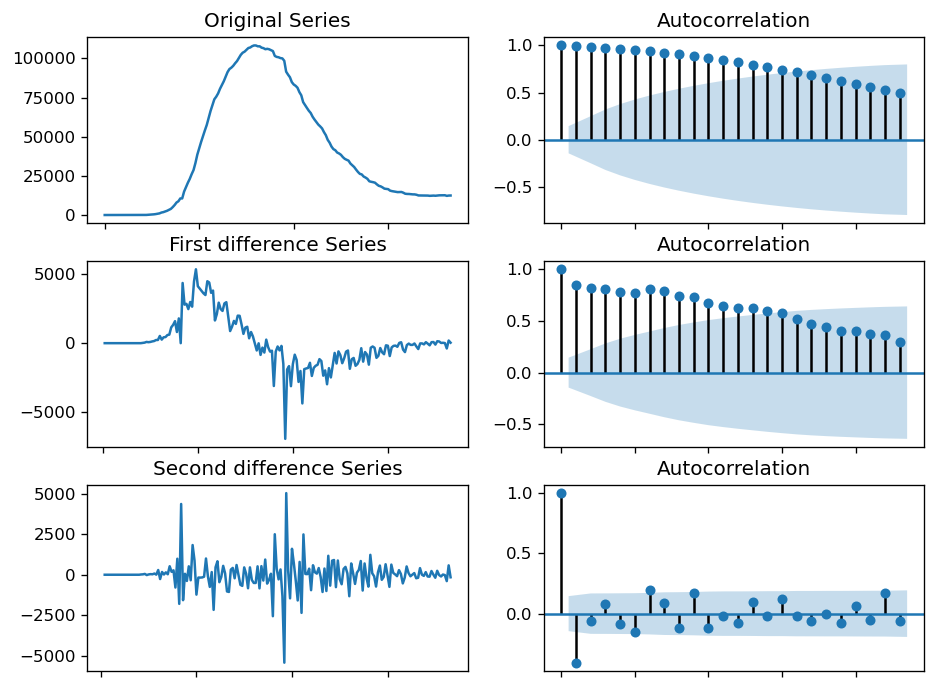

In [254]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(9, 7), sharex=False)

axes[0, 0].plot(df); axes[0, 0].set_title('Original Series'); axes[0, 0].set_xticklabels([])
plot_acf(df, ax=axes[0, 1]); axes[0, 1].set_xticklabels([])

axes[1, 0].plot(df.diff()); axes[1, 0].set_title('First difference Series'); axes[1, 0].set_xticklabels([])
plot_acf(df.diff().dropna(), ax=axes[1, 1]); axes[1, 1].set_xticklabels([])

axes[2, 0].plot(df.diff().diff()); axes[2, 0].set_title('Second difference Series'); axes[2, 0].set_xticklabels([])
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1]); axes[2, 1].set_xticklabels([])

plt.show()

In [255]:
temp = df.diff().diff().dropna()
result = adfuller(temp)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.016937
p-value: 0.001324


Như vậy chọn mô hình arima có tham số d = 2

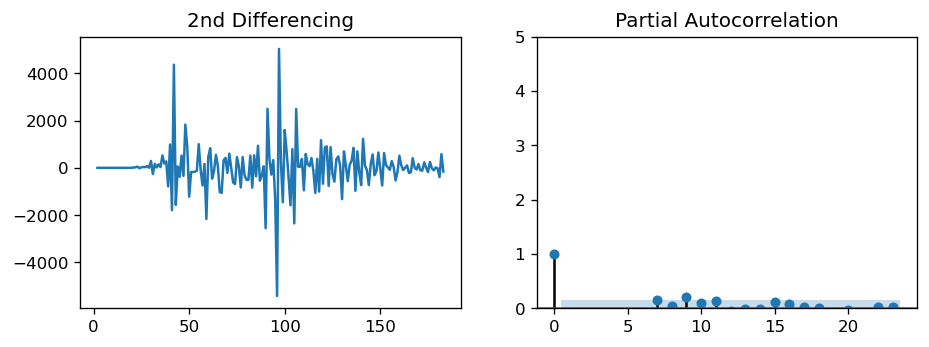

In [256]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(temp.dropna(), ax=axes[1])

plt.show()

Chọn p = 1

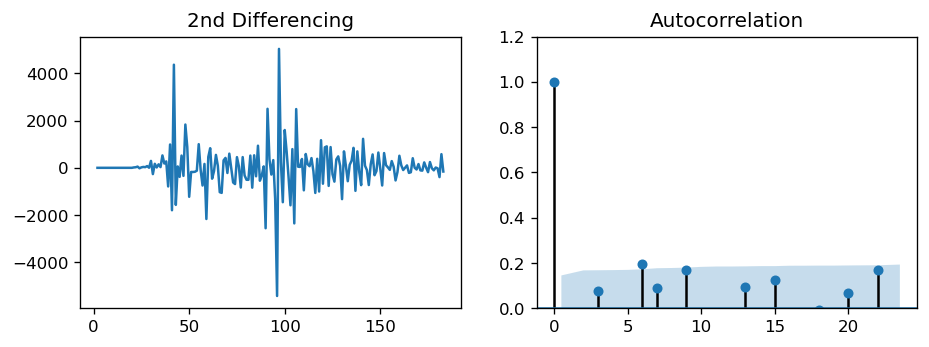

In [257]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

# Import data

fig, axes = plt.subplots(1, 2)
axes[0].plot(temp); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(temp.dropna(), ax=axes[1])

plt.show()

Chọn q = 1

In [258]:
print(df.shape)
n = 40

train = df.iloc[:-n]
test  = df.iloc[-n:]

print(train.shape)
print(test.shape)

(184, 1)
(144, 1)
(40, 1)


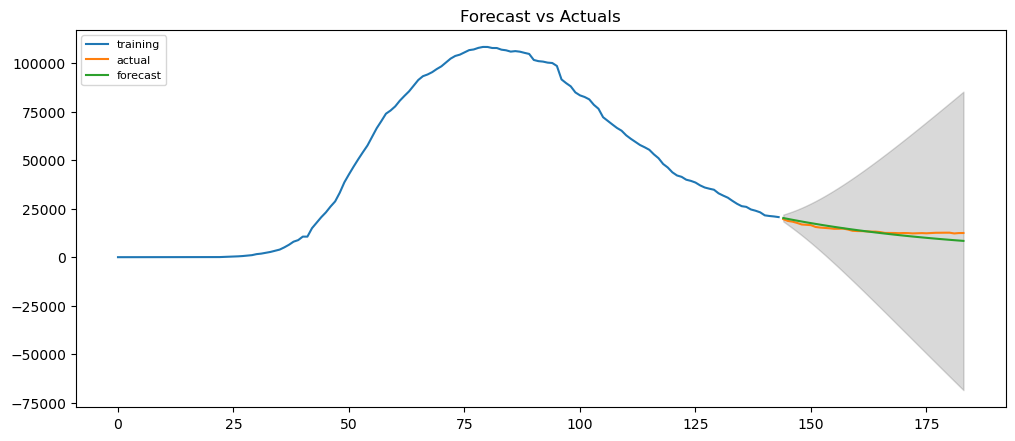

In [260]:
from statsmodels.tsa.arima_model import ARIMA
# Build Model
model = ARIMA(train, order=(2,1,1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(n, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()